In [2]:
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error
from data.covid_recovery import Covid
from data.injury_labeller.injuryScore import injuryScore
from datetime import datetime, timedelta
from neuralprophet import NeuralProphet
import pandas as pd
from scipy.special import expit
import logging

In [3]:
data = Covid().get_dataset()

WARNING - (py.warnings._showwarnmsg) - /Users/chasecotton/ml-covid-nba/venv/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)



In [4]:
data.head()

,Player,Team,Deactivated,Activated,Player_ID
0,Rajon Rondo,Hawks,2020-12-22,2020-12-26,rondora01
1,Kenyon Martin Jr.,Rockets,2020-12-23,2021-01-03,martike04
2,Mamadi Diakite,Bucks,2020-12-25,2021-03-11,diakima01
3,Javonte Green,Celtics,2020-12-30,2021-01-08,greenja02
4,Chandler Hutchison,Bulls,2020-12-31,2021-01-22,hutchch01


In [111]:
data = Covid().get_dataset()
all_tables = []
lag = 3
count = 0
for index, row in data.loc[:, 'Deactivated':'Player_ID'].iterrows():
    if len(row.Player_ID) > 1:
        try:
            year = 2021 if pd.to_datetime(row.Activated) < datetime(2021, 6, 1) else 2022
            table = injuryScore(row.Player_ID, 2021).getInjuryScore()
        except (IndexError, ValueError):
            continue
        table.index = pd.to_datetime(table.Date)
        table = table.groupby(table.index).mean().resample('D').interpolate().loc[
                pd.to_datetime(row.Activated):pd.to_datetime(row.Activated) + timedelta(days=30)]
        if len(table) == 31:
            table = pd.concat([pd.DataFrame({'ds': pd.date_range(end=table.index[0] - timedelta(days=1), periods=lag, freq='D'),
                                             'y': np.zeros(lag)}),
                               pd.DataFrame({'ds': table.index,
                                             'y': table['Injury and Fatigue Score']})])
            all_tables.append(table)

In [113]:
df['days_out'] = df.apply(lambda row: pd.to_datetime(row.Activated) - pd.to_datetime(row.Deactivated), axis=1)
print(df.days_out.max())
df.head()

76 days 00:00:00


,Player,Team,Deactivated,Activated,days_out
402,Rajon Rondo,Hawks,2020-12-22,2020-12-26,4 days
429,Kenyon Martin Jr.,Rockets,2020-12-23,2021-01-03,11 days
432,Mamadi Diakite,Bucks,2020-12-25,2021-03-11,76 days
476,Javonte Green,Celtics,2020-12-30,2021-01-08,9 days
487,Chandler Hutchison,Bulls,2020-12-31,2021-01-22,22 days


In [114]:
ts = pd.DataFrame(columns={'health'})
ts.health = np.concatenate((np.ones(6),np.zeros(df.days_out.iloc[0].days),np.linspace(.1,1,5),np.ones(10)))
ts = ts.append(pd.DataFrame(np.concatenate((np.ones(3),np.zeros(7),np.linspace(.1,1,9),np.ones(10))).T, columns={'health'}))
ts = ts.append(pd.DataFrame(np.concatenate((np.ones(3),np.zeros(7),np.linspace(.1,1,6),np.ones(1))).T, columns={'health'}))
ts.index = pd.date_range('2020-03-10', freq='D', periods=len(ts))
ts

,health
2020-03-10,1.00
2020-03-11,1.00
2020-03-12,1.00
2020-03-13,1.00
2020-03-14,1.00
...,...
2020-05-15,0.46
2020-05-16,0.64
2020-05-17,0.82
2020-05-18,1.00


In [115]:
np_df = ts.copy()
np_df.rename({'health':'y'},axis=1,inplace=True)
np_df['ds'] = np_df.index
train_df = np_df[:-5]
test_df = np_df[-5:]
model = NeuralProphet(n_lags=10, n_forecasts=5)
model.fit(train_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 623


  0%|          | 0/189 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.63E-02, min: 7.83E-01


  0%|          | 0/189 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.73E-02, min: 1.22E+00


  0%|          | 0/189 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.08E-01, min: 5.62E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.96E-02
Epoch[623/623]: 100%|██████████| 623/623 [00:04<00:00, 133.82it/s, SmoothL1Loss=0.0117, MAE=0.113, RMSE=0.151, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.834492,1.245562,1.524191,0.0
1,0.818838,1.229828,1.504458,0.0
2,0.803505,1.214122,1.479788,0.0
3,0.788472,1.198617,1.460539,0.0
4,0.773037,1.183103,1.442167,0.0
...,...,...,...,...
618,0.011736,0.112743,0.151596,0.0
619,0.011736,0.112748,0.150916,0.0
620,0.011736,0.112748,0.149202,0.0
621,0.011736,0.112748,0.152480,0.0


In [116]:
pred = model.predict(model.make_future_dataframe(df=train_df))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [117]:
pred = abs(pred.fillna(method='bfill', axis=1).y[-5:])
mean_squared_error(test_df.y, pred)

0.06156082895129823

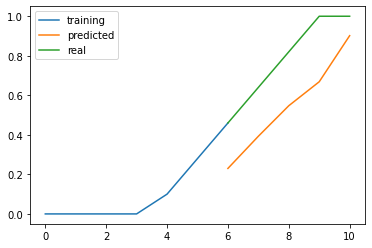

In [118]:
plt.plot(range(7), np.concatenate((train_df.y.values[-6:],[test_df.y[0]])), label='training')
plt.plot(range(6, 6 + len(test_df)), pred.values, label='predicted')
plt.plot(range(6, 6 + len(test_df)), test_df.y.values, label='real')
plt.legend()
plt.show()